### Mayra Pachacama | Brayan Cunduri | Elisa Herrera Grupo 3

# 10.7. Sequence-to-Sequence Learning for Machine Translation

In so-called sequence-to-sequence problems such as machine translation (as discussed in Section 10.5), where inputs and outputs each consist of variable-length unaligned sequences, we generally rely on encoder–decoder architectures (Section 10.6). In this section, we will demonstrate the application of an encoder–decoder architecture, where both the encoder and decoder are implemented as RNNs, to the task of machine translation (Cho et al., 2014, Sutskever et al., 2014).

Here, the encoder RNN will take a variable-length sequence as input and transform it into a fixed-shape hidden state. Later, in Section 11, we will introduce attention mechanisms, which allow us to access encoded inputs without having to compress the entire input into a single fixed-length representation.

Then to generate the output sequence, one token at a time, the decoder model, consisting of a separate RNN, will predict each successive target token given both the input sequence and the preceding tokens in the output. During training, the decoder will typically be conditioned upon the preceding tokens in the official “ground truth” label. However, at test time, we will want to condition each output of the decoder on the tokens already predicted. Note that if we ignore the encoder, the decoder in a sequence-to-sequence architecture behaves just like a normal language model. Fig. 10.7.1 illustrates how to use two RNNs for sequence-to-sequence learning in machine translation.

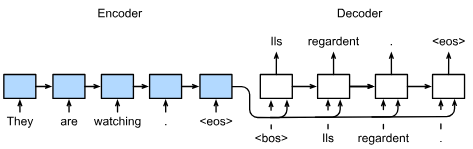


Fig. 10.7.1 Sequence-to-sequence learning with an RNN encoder and an RNN decoder.¶


In Fig. 10.7.1, the special “<eos>” token marks the end of the sequence. Our model can stop making predictions once this token is generated. At the initial time step of the RNN decoder, there are two special design decisions to be aware of: First, we begin every input with a special beginning-of-sequence “<bos>” token. Second, we may feed the final hidden state of the encoder into the decoder at every single decoding time step (Cho et al., 2014). In some other designs, such as that of Sutskever et al. (2014), the final hidden state of the RNN encoder is used to initiate the hidden state of the decoder only at the first decoding step.

In [37]:
use strict; 
use warnings; 
use Data::Dump qw(dump); 
use AI::MXNet qw(mx);
use constant np => 'numperl';
use Chart::Plotly::Trace::Image;
IPerl->load_plugin('Chart::Plotly'); 
use PDL;


### 10.7.1. Teacher Forcing
While running the encoder on the input sequence is relatively straightforward, handling the input and output of the decoder requires more care. The most common approach is sometimes called teacher forcing. Here, the original target sequence (token labels) is fed into the decoder as input. More concretely, the special beginning-of-sequence token and the original target sequence, excluding the final token, are concatenated as input to the decoder, while the decoder output (labels for training) is the original target sequence, shifted by one token: “<bos>”, “Ils”, “regardent”, “.” 
 “Ils”, “regardent”, “.”, “<eos>” (Fig. 10.7.1).

Our implementation in Section 10.5.3 prepared training data for teacher forcing, where shifting tokens for self-supervised learning is similar to the training of language models in Section 9.3. An alternative approach is to feed the predicted token from the previous time step as the current input to the decoder.

In the following, we explain the design depicted in Fig. 10.7.1 in greater detail. We will train this model for machine translation on the English–French dataset as introduced in Section 10.5.

### 10.7.2. Encoder
Recall that the encoder transforms an input sequence of variable length into a fixed-shape context variable 
 (see Fig. 10.7.1).

Consider a single sequence example (batch size 1). Suppose the input sequence is 
, such that 
 is the 
 token. At time step 
, the RNN transforms the input feature vector 
 for 
 and the hidden state 
 from the previous time step into the current hidden state 
. We can use a function 
 to express the transformation of the RNN’s recurrent layer:

 <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">h</mi>
    </mrow>
    <mi>t</mi>
  </msub>
  <mo>=</mo>
  <mi>f</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">x</mi>
    </mrow>
    <mi>t</mi>
  </msub>
  <mo>,</mo>
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">h</mi>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>                                                                                (10.7.1)¶


In general, the encoder transforms the hidden states at all time steps into a context variable through a customized function 
:


<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">c</mi>
  </mrow>
  <mo>=</mo>
  <mi>q</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">h</mi>
    </mrow>
    <mn>1</mn>
  </msub>
  <mo>,</mo>
  <mo>&#x2026;</mo>
  <mo>,</mo>
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">h</mi>
    </mrow>
    <mi>T</mi>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>

                                                                   (10.7.2)



For example, in Fig. 10.7.1, the context variable is just the hidden state 
 corresponding to the encoder RNN’s representation after processing the final token of the input sequence.

In this example, we have used a unidirectional RNN to design the encoder, where the hidden state only depends on the input subsequence at and before the time step of the hidden state. We can also construct encoders using bidirectional RNNs. In this case, a hidden state depends on the subsequence before and after the time step (including the input at the current time step), which encodes the information of the entire sequence.

Now let’s implement the RNN encoder. Note that we use an embedding layer to obtain the feature vector for each token in the input sequence. The weight of an embedding layer is a matrix, where the number of rows corresponds to the size of the input vocabulary (vocab_size) and number of columns corresponds to the feature vector’s dimension (embed_size). For any input token index 
, the embedding layer fetches the 
 row (starting from 0) of the weight matrix to return its feature vector. Here we implement the encoder with a multilayer GRU.

In [41]:
{
    # Función para inicializar pesos en un módulo
    sub init_seq2seq {
        my $module = shift;

        if (ref $module eq 'PDL::Linear') {
            xavier_uniform_($module->weight);
        }

        if (ref $module eq 'PDL::GRU') {
            for my $param (@{ $module->_flat_weights_names }) {
                if ($param =~ /weight/) {
                    xavier_uniform_($module->_parameters->{$param});
                }
            }
        }  
    }

    # Definir clase equivalente a "Seq2SeqEncoder"
    package Seq2SeqEncoder;

    use PDL::PP;

    our @ISA = qw(d2l.Encoder);

    # Constructor de la clase
    sub new {
        my ($class, $vocab_size, $embed_size, $num_hiddens, $num_layers, $dropout) = @_;
        my $self = $class->SUPER::new();

        $self->{embedding} = PDL::Embedding->new($vocab_size, $embed_size);
        $self->{rnn} = PDL::GRU->new($embed_size, $num_hiddens, $num_layers, $dropout);
        $self->apply(\&init_seq2seq);

        bless $self, $class;
        return $self;
    }

    # Método "forward" equivalente
    sub forward {
        my ($self, $X, @args) = @_;

        my $embs = $self->{embedding}->forward($X->transpose->long);
        my ($outputs, $state) = $self->{rnn}->forward($embs);

        return $outputs, $state;
    }
}

1;

1

Warning: Use of uninitialized value $packname in pattern match (m//) at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/PDL/PP.pm line 737.


Let’s use a concrete example to illustrate the above encoder implementation. Below, we instantiate a two-layer GRU encoder whose number of hidden units is 16. Given a minibatch of sequence inputs X (batch size 
; number of time steps 
), the hidden states of the final layer at all the time steps (enc_outputs returned by the encoder’s recurrent layers) are a tensor of shape (number of time steps, batch size, number of hidden units).

In [42]:
# Parámetros
my ($vocab_size, $embed_size, $num_hiddens, $num_layers) = (10, 8, 16, 2);
my ($batch_size, $num_steps) = (4, 9);

# Instancia de Seq2SeqEncoder
my $encoder = Seq2SeqEncoder->new($vocab_size, $embed_size, $num_hiddens, $num_layers);

# Operación forward
my ($enc_outputs, $enc_state) = $encoder->forward(zeros($batch_size, $num_steps));

# Verificar forma
check_shape($enc_outputs, [$num_steps, $batch_size, $num_hiddens]);

Warning: While trying to resolve method call Seq2SeqEncoder->new() can not locate package "d2l.Encoder" yet it is mentioned in @Seq2SeqEncoder::ISA (perhaps you forgot to load "d2l.Encoder"?) at reply input line 29.


Error: Can't locate object method "new" via package "Seq2SeqEncoder" at reply input line 29.


Since we are using a GRU here, the shape of the multilayer hidden states at the final time step is (number of hidden layers, batch size, number of hidden units).

In [43]:
check_shape($enc_state, [$num_layers, $batch_size, $num_hiddens]);

Error: Undefined subroutine &Seq2SeqEncoder::check_shape called at reply input line 1.


### 10.7.3. Decoder
Given a target output sequence 
 for each time step 
 (we use 
 to differentiate from the input sequence time steps), the decoder assigns a predicted probability to each possible token occurring at step 
 conditioned upon the previous tokens in the target 
 and the context variable 
, i.e., 
.

To predict the subsequent token 
 in the target sequence, the RNN decoder takes the previous step’s target token 
, the hidden RNN state from the previous time step 
, and the context variable 
 as its input, and transforms them into the hidden state 
 at the current time step. We can use a function 
 to express the transformation of the decoder’s hidden layer:
 
 <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">s</mi>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <msup>
        <mi>t</mi>
        <mi data-mjx-alternate="1">&#x2032;</mi>
      </msup>
    </mrow>
  </msub>
  <mo>=</mo>
  <mi>g</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <msup>
        <mi>t</mi>
        <mi data-mjx-alternate="1">&#x2032;</mi>
      </msup>
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msub>
  <mo>,</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">c</mi>
  </mrow>
  <mo>,</mo>
  <msub>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">s</mi>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <msup>
        <mi>t</mi>
        <mi data-mjx-alternate="1">&#x2032;</mi>
      </msup>
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>

(10.7.3)
After obtaining the hidden state of the decoder, we can use an output layer and the softmax operation to compute the predictive distribution 
 over the subsequent output token 
.

Following Fig. 10.7.1, when implementing the decoder as follows, we directly use the hidden state at the final time step of the encoder to initialize the hidden state of the decoder. This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units. To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps. To predict the probability distribution of the output token, we use a fully connected layer to transform the hidden state at the final layer of the RNN decoder.

In [44]:
# Definición de la clase Seq2SeqDecoder
package Seq2SeqDecoder;

use PDL::PP;

our @ISA = qw(d2l.Decoder);

# Constructor de la clase
sub new {
    my ($class, $vocab_size, $embed_size, $num_hiddens, $num_layers, $dropout) = @_;
    my $self = $class->SUPER::new();

    $self->{embedding} = PDL::Embedding->new($vocab_size, $embed_size);
    $self->{rnn} = PDL::GRU->new($embed_size + $num_hiddens, $num_hiddens, $num_layers, $dropout);
    $self->{dense} = PDL::LazyLinear->new($vocab_size);
    $self->apply(\&init_seq2seq);

    bless $self, $class;
    return $self;
}

# Método "init_state" equivalente
sub init_state {
    my ($self, $enc_all_outputs, @args) = @_;
    return $enc_all_outputs;
}

# Método "forward" equivalente
sub forward {
    my ($self, $X, $state) = @_;

    my $embs = $self->{embedding}->forward($X->transpose->long);
    my ($enc_output, $hidden_state) = @$state;
    my $context = $enc_output->index(-1);
    $context = $context->replicate(1, $embs->dim(0), 1);
    my $embs_and_context = $embs->cat($context, -1);
    my ($outputs, $new_hidden_state) = $self->{rnn}->forward($embs_and_context, $hidden_state);
    $outputs = $self->{dense}->forward($outputs)->transpose(0, 1);
    
    return $outputs, [$enc_output, $new_hidden_state];
}

1;


1

Warning: Use of uninitialized value $packname in pattern match (m//) at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/PDL/PP.pm line 737.


To illustrate the implemented decoder, below we instantiate it with the same hyperparameters from the aforementioned encoder. As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size), where the final dimension of the tensor stores the predicted token distribution.

In [46]:
# Crear una instancia de Seq2SeqDecoder
my $decoder = Seq2SeqDecoder->new($vocab_size, $embed_size, $num_hiddens, $num_layers);

# Inicializar el estado del decoder
my $state = $decoder->init_state($encoder->forward(my $X));

# Realizar la propagación hacia adelante
my ($dec_outputs, $new_state) = $decoder->forward($X, $state);

# Verificar las formas usando check_shape
check_shape($dec_outputs, [$batch_size, $num_steps, $vocab_size]);
check_shape($new_state->[1], [$num_layers, $batch_size, $num_hiddens]);


Warning: While trying to resolve method call Seq2SeqDecoder->new() can not locate package "d2l.Decoder" yet it is mentioned in @Seq2SeqDecoder::ISA (perhaps you forgot to load "d2l.Decoder"?) at reply input line 11.


Error: Can't locate object method "new" via package "Seq2SeqDecoder" at reply input line 11.


The layers in the above RNN encoder–decoder model are summarized in Fig. 10.7.2.

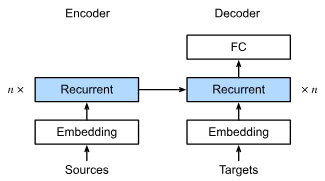

Fig. 10.7.2 Layers in an RNN encoder–decoder model.

### 10.7.4. Encoder–Decoder for Sequence-to-Sequence Learning

In [47]:
# Definición de la clase Seq2Seq
package Seq2Seq;

use PDL::PP;

our @ISA = qw(d2l.EncoderDecoder);

# Constructor de la clase
sub new {
    my ($class, $encoder, $decoder, $tgt_pad, $lr) = @_;
    my $self = $class->SUPER::new($encoder, $decoder);

    $self->{tgt_pad} = $tgt_pad;
    $self->{lr} = $lr;

    bless $self, $class;
    return $self;
}

# Método "validation_step" equivalente
sub validation_step {
    my ($self, $batch) = @_;
    my $Y_hat = $self->forward(@$batch[0..$#{$batch}-1]);
    $self->plot('loss', $self->loss($Y_hat, $batch->[-1]), train => 0);
}

# Método "configure_optimizers" equivalente
sub configure_optimizers {
    my ($self) = @_;
    return PDL::Adam->new($self->parameters, lr => $self->{lr});
}

1;


1

Warning: Use of uninitialized value $packname in pattern match (m//) at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/PDL/PP.pm line 737.


### 10.7.5. Loss Function with Masking
At each time step, the decoder predicts a probability distribution for the output tokens. As with language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall from Section 10.5 that the special padding tokens are appended to the end of sequences and so sequences of varying lengths can be efficiently loaded in minibatches of the same shape. However, prediction of padding tokens should be excluded from loss calculations. To this end, we can mask irrelevant entries with zero values so that multiplication of any irrelevant prediction with zero equates to zero.

In [49]:
# Método "loss" equivalente
sub loss {
    my ($self, $Y_hat, $Y) = @_;
    my $l = $self->SUPER::loss($Y_hat, $Y, averaged => 0);
    my $mask = ($Y->reshape(-1) != $self->{tgt_pad})->float;
    return ($l * $mask)->sum / $mask->sum;
}


Warning: Subroutine loss redefined at reply input line 2.


### 10.7.6. Training
Now we can create and train an RNN encoder–decoder model for sequence-to-sequence learning on the machine translation dataset.

In [50]:
# Creación del objeto de datos
my $data = d2l::MTFraEng->new(batch_size => 128);

# Definición de parámetros
my ($embed_size, $num_hiddens, $num_layers, $dropout) = (256, 256, 2, 0.2);

# Creación del codificador y decodificador
my $encoder = Seq2SeqEncoder->new(
    scalar(@{ $data->src_vocab }), $embed_size, $num_hiddens, $num_layers, $dropout
);
my $decoder = Seq2SeqDecoder->new(
    scalar(@{ $data->tgt_vocab }), $embed_size, $num_hiddens, $num_layers, $dropout
);

# Creación del modelo Seq2Seq
my $model = Seq2Seq->new(
    encoder => $encoder,
    decoder => $decoder,
    tgt_pad => $data->tgt_vocab->{'<pad>'},
    lr      => 0.005
);

# Configuración del entrenador
my $trainer = d2l::Trainer->new(
    max_epochs       => 30,
    gradient_clip_val => 1,
    num_gpus         => 1
);

# Entrenamiento del modelo
$trainer->fit($model, $data);



Error: Can't locate object method "new" via package "d2l::MTFraEng" (perhaps you forgot to load "d2l::MTFraEng"?) at reply input line 2.


### 10.7.7. Prediction
To predict the output sequence at each step, the predicted token from the previous time step is fed into the decoder as an input. One simple strategy is to sample whichever token that has been assigned by the decoder the highest probability when predicting at each step. As in training, at the initial time step the beginning-of-sequence (“<bos>”) token is fed into the decoder. This prediction process is illustrated in Fig. 10.7.3. When the end-of-sequence (“<eos>”) token is predicted, the prediction of the output sequence is complete.

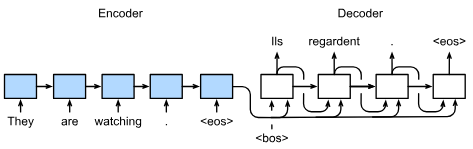

Fig. 10.7.3 Predicting the output sequence token by token using an RNN encoder–decoder.

In the next section, we will introduce more sophisticated strategies based on beam search (Section 10.8).

In [51]:
sub predict_step {
    my ($self, $batch, $device, $num_steps, $save_attention_weights) = @_;
    
    # Convertir datos a dispositivo
    my @batch = map { $_->to($device) } @$batch;
    my ($src, $tgt, $src_valid_len, $dummy) = @batch;
    
    # Obtener salidas del codificador
    my $enc_all_outputs = $self->{encoder}->forward($src, $src_valid_len);
    
    # Inicializar estado del decodificador
    my $dec_state = $self->{decoder}->init_state($enc_all_outputs, $src_valid_len);
    
    # Inicializar salidas y pesos de atención
    my @outputs = ($tgt->(:, (0))->unsqueeze(1));
    my @attention_weights = ();
    
    # Bucle para generar predicciones
    for (my $i = 0; $i < $num_steps; $i++) {
        my ($Y, $new_dec_state) = $self->{decoder}->forward($outputs[-1], $dec_state);
        push @outputs, $Y->argmax(2);
        
        # Guardar pesos de atención (para ser cubiertos más tarde)
        if ($save_attention_weights) {
            push @attention_weights, $self->{decoder}->{attention_weights};
        }
        
        $dec_state = $new_dec_state;
    }
    
    # Concatenar salidas y devolver resultados
    return torch->cat(\@outputs[1:], 1), \@attention_weights;
}


Error: syntax error at reply input line 15, near "(:"
syntax error at reply input line 32, near "1:"
BEGIN not safe after errors--compilation aborted at reply input line 38.



### 10.7.8. Evaluation of Predicted Sequences
We can evaluate a predicted sequence by comparing it with the target sequence (the ground truth). But what precisely is the appropriate measure for comparing similarity between two sequences?

Bilingual Evaluation Understudy (BLEU), though originally proposed for evaluating machine translation results (Papineni et al., 2002), has been extensively used in measuring the quality of output sequences for different applications. In principle, for any 
-gram (Section 9.3.1.1) in the predicted sequence, BLEU evaluates whether this 
-gram appears in the target sequence.

Denote by 
 the precision of an 
-gram, defined as the ratio of the number of matched 
-grams in the predicted and target sequences to the number of 
-grams in the predicted sequence. To explain, given a target sequence 
, 
, 
, 
, 
, 
, and a predicted sequence 
, 
, 
, 
, 
, we have 
, 
, 
, and 
. Now let 
 and 
 be the numbers of tokens in the target sequence and the predicted sequence, respectively. Then, BLEU is defined as

(10.7.4)
 
where 
 is the longest 
-gram for matching.

Based on the definition of BLEU in (10.7.4), whenever the predicted sequence is the same as the target sequence, BLEU is 1. Moreover, since matching longer 
-grams is more difficult, BLEU assigns a greater weight when a longer 
-gram has high precision. Specifically, when 
 is fixed, 
 increases as 
 grows (the original paper uses 
). Furthermore, since predicting shorter sequences tends to yield a higher 
 value, the coefficient before the multiplication term in (10.7.4) penalizes shorter predicted sequences. For example, when 
, given the target sequence 
, 
, 
, 
, 
, 
 and the predicted sequence 
, 
, although 
, the penalty factor 
 lowers the BLEU.

We implement the BLEU measure as follows.

In [52]:
sub bleu {
    my ($pred_seq, $label_seq, $k) = @_;

    my @pred_tokens = split(' ', $pred_seq);
    my @label_tokens = split(' ', $label_seq);

    my $len_pred = scalar @pred_tokens;
    my $len_label = scalar @label_tokens;

    my $score = exp(min(0, 1 - $len_label / $len_pred));

    for my $n (1..min($k, $len_pred)) {
        my $num_matches = 0;
        my %label_subs;

        for my $i (0..$len_label - $n) {
            $label_subs{join(' ', @label_tokens[$i..$i + $n - 1])} += 1;
        }

        for my $i (0..$len_pred - $n) {
            if ($label_subs{join(' ', @pred_tokens[$i..$i + $n - 1])} > 0) {
                $num_matches += 1;
                $label_subs{join(' ', @pred_tokens[$i..$i + $n - 1])} -= 1;
            }
        }

        $score *= pow($num_matches / ($len_pred - $n + 1), pow(0.5, $n));
    }

    return $score;
}


In the end, we use the trained RNN encoder–decoder to translate a few English sentences into French and compute the BLEU of the results.

In [53]:
use List::Util qw(min);

my @engs = ('go .', 'i lost .', 'he\'s calm .', 'i\'m home .');
my @fras = ('va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .');

# Simulación de la función predict_step
my @preds;
foreach my $eng (@engs) {
    my @tokens = split(' ', $eng);
    my $p = \@tokens;  # Simulación de la salida del modelo
    push @preds, $p;
}

for my $i (0..$#engs) {
    my $en = $engs[$i];
    my $fr = $fras[$i];
    my $p = $preds[$i];

    my @translation;
    foreach my $token (@$p) {
        last if $token eq '<eos>';
        push @translation, $token;
    }

    my $bleu_score = bleu(join(' ', @translation), $fr, 2);
    print "$en => [@translation], bleu, $bleu_score\n";
}

sub bleu {
    my ($pred_seq, $label_seq, $k) = @_;

    my @pred_tokens = split(' ', $pred_seq);
    my @label_tokens = split(' ', $label_seq);

    my $len_pred = scalar @pred_tokens;
    my $len_label = scalar @label_tokens;

    my $score = exp(min(0, 1 - $len_label / $len_pred));

    for my $n (1..min($k, $len_pred)) {
        my $num_matches = 0;
        my %label_subs;

        for my $i (0..$len_label - $n) {
            $label_subs{join(' ', @label_tokens[$i..$i + $n - 1])} += 1;
        }

        for my $i (0..$len_pred - $n) {
            if ($label_subs{join(' ', @pred_tokens[$i..$i + $n - 1])} > 0) {
                $num_matches += 1;
                $label_subs{join(' ', @pred_tokens[$i..$i + $n - 1])} -= 1;
            }
        }

        $score *= pow($num_matches / ($len_pred - $n + 1), pow(0.5, $n));
    }

    return $score;
}


Warning: Subroutine bleu redefined at reply input line 29.

Use of uninitialized value within %label_subs in numeric gt (>) at reply input line 49.

Use of uninitialized value within %label_subs in numeric gt (>) at reply input line 49.


Error: Undefined subroutine &Seq2Seq::pow called at reply input line 55.


### 10.7.9. Summary
Following the design of the encoder–decoder architecture, we can use two RNNs to design a model for sequence-to-sequence learning. In encoder–decoder training, the teacher forcing approach feeds original output sequences (in contrast to predictions) into the decoder. When implementing the encoder and the decoder, we can use multilayer RNNs. We can use masks to filter out irrelevant computations, such as when calculating the loss. For evaluating output sequences, BLEU is a popular measure that matches 
-grams between the predicted sequence and the target sequence.

### 10.7.10. Exercises
Can you adjust the hyperparameters to improve the translation results?

Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?

If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?

In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?

Rerun the experiment by replacing GRU with LSTM.

Are there any other ways to design the output layer of the decoder?